In [94]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import regex as re
import math

from matplotlib.ticker import MultipleLocator

%matplotlib inline

In [84]:
def minutes_to_hhmm(minutes):
    hours = int(minutes // 60)
    mins = int(minutes % 60)
    return f'{hours:02d}:{mins:02d}'

def recursive_replace(pattern, replacement, text):
    regex = re.compile(pattern)
    previous_text = None

    while previous_text != text:
        previous_text = text
        text = regex.sub(replacement, text)

    return text.strip()

In [85]:

df = pd.read_csv('chat_per_minute.csv')

total_messages_per_minute = pd.DataFrame({
    'minute': df['minute'],
    'message_count': df['total']
})

member_messages_per_minute = pd.DataFrame({
    'minute': df['minute'],
    'message_count': df['member']
})


moving_average = pd.DataFrame({
    'minute': df['minute'],
    'message_count': df['mv10']
})


In [86]:
time_labels = pd.to_datetime(total_messages_per_minute['minute'], unit='m').dt.strftime('%H:%M')

time_labels_10min = time_labels[::10]
minutes_10min = total_messages_per_minute['minute'][::10]

In [87]:
mean_frequency = moving_average['message_count'].mean()
std_dev_frequency = moving_average['message_count'].std()

peak_threshold = mean_frequency + 1.96 * std_dev_frequency

peaks = total_messages_per_minute[total_messages_per_minute['message_count'] > peak_threshold].copy(True)
peaks['text_minute'] =  pd.to_datetime(peaks['minute'], unit='m').dt.strftime('%H:%M:%S')

In [88]:
peak_start_end = pd.DataFrame({
    'minute': total_messages_per_minute['minute'],
    'chat_frequency': total_messages_per_minute['message_count'],
    'moving_average': moving_average['message_count']
})
peak_start_end['is_above_average'] = peak_start_end['chat_frequency'] > peak_start_end['moving_average']
# .shift() 將 is_above_average 欄位的數值往後移動一個位置，這樣可以比較當前的值和前一個值。
# .ne() 比較當前值和前一個值是否不同。如果不同，表示出現了趨勢的變化（從低於到高於，或從高於到低於）。
# .cumsum() 累積計數，為每個趨勢變化賦予一個唯一的組別號碼。這樣可以將每個連續的 True 或 False 區間歸類在一起。
peak_transitions = peak_start_end['is_above_average'].ne(peak_start_end['is_above_average'].shift()).cumsum()

# 對每個分組，檢查該區間內的所有值是否都為 True，也就是確定這段時間都處於峰值。如果是，則返回該區間的起點和終點（x.index.min() 和 x.index.max()）
start_end_times = peak_start_end.groupby(peak_transitions).apply(lambda x: (x.index.min(), x.index.max()) if x['is_above_average'].all() else None).dropna()

start_end_times.head()

is_above_average
2       (5, 9)
4     (11, 13)
6     (22, 23)
8     (26, 26)
10    (30, 31)
dtype: object

In [89]:
range_threashold = 3
merged_intervals = []
previous_start, previous_end = None, None

for start, end in start_end_times:
    if previous_start is None:
        # Initialize the first interval
        previous_start, previous_end = start, end
    elif start - previous_end <= range_threashold:
        # Merge the intervals if the gap is less than threashold
        previous_end = end
    else:
        # Save the previous interval and start a new one
        merged_intervals.append((previous_start, previous_end))
        previous_start, previous_end = start, end

# Append the last interval
if previous_start is not None:
    merged_intervals.append((previous_start, previous_end))

print(merged_intervals)

[(np.int64(5), np.int64(13)), (np.int64(22), np.int64(26)), (np.int64(30), np.int64(31)), (np.int64(36), np.int64(38)), (np.int64(42), np.int64(47)), (np.int64(56), np.int64(80)), (np.int64(93), np.int64(104)), (np.int64(108), np.int64(125)), (np.int64(129), np.int64(129)), (np.int64(133), np.int64(133)), (np.int64(138), np.int64(138)), (np.int64(142), np.int64(142)), (np.int64(149), np.int64(165))]


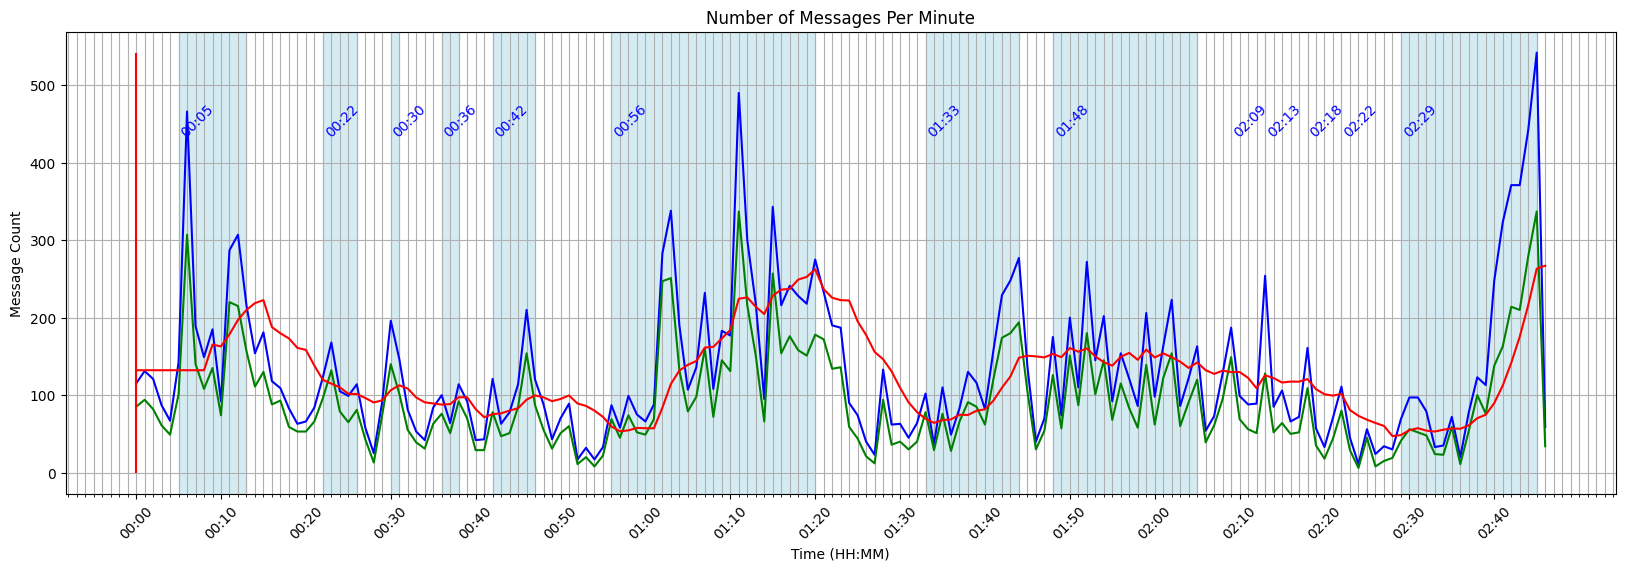

In [90]:
plt.figure(figsize=(20, 6))

plt.plot(total_messages_per_minute['minute'], total_messages_per_minute['message_count'], label='Total Messages', color='blue')

plt.plot(member_messages_per_minute['minute'], member_messages_per_minute['message_count'], label='Member Messages', color='green')

plt.plot(moving_average['minute'], moving_average['message_count'], label="Moving Average", color='red')

for start, end in merged_intervals:
    plt.axvspan(start, end, color='lightblue', alpha=0.5)
    plt.text(start, total_messages_per_minute['message_count'].max() * 0.8, minutes_to_hhmm(start), color='blue', fontsize=10, rotation=45)

plt.vlines(0, ymin=0, ymax=total_messages_per_minute['message_count'].max(), colors='red')

plt.xticks(ticks=minutes_10min, labels=time_labels_10min, rotation=45)
plt.gca().xaxis.set_minor_locator(MultipleLocator(1))
plt.xlabel('Time (HH:MM)')
plt.ylabel('Message Count')
plt.title('Number of Messages Per Minute')

plt.grid(True, which='both')
plt.show()

In [93]:
df_origin = pd.read_csv('chat.csv')
with open('filter.txt', 'r', encoding='utf8') as f:
    filter_words = [word.strip() for word in f.readlines()]
pattern = re.compile(r'\b(' + '|'.join(filter_words) +
                    r')\b|(:[^:]+:)|(\(.*?\)[^\w\s]*)|(^\@\w+\s$)|(^\?+$)|\p{S}|\p{P}|\p{C}', re.IGNORECASE)
df_origin['cleaned_message'] = df_origin['message'].apply(
    lambda x:  recursive_replace(pattern, '', x)).replace('', np.nan)

df_origin = df_origin.dropna(subset='cleaned_message')

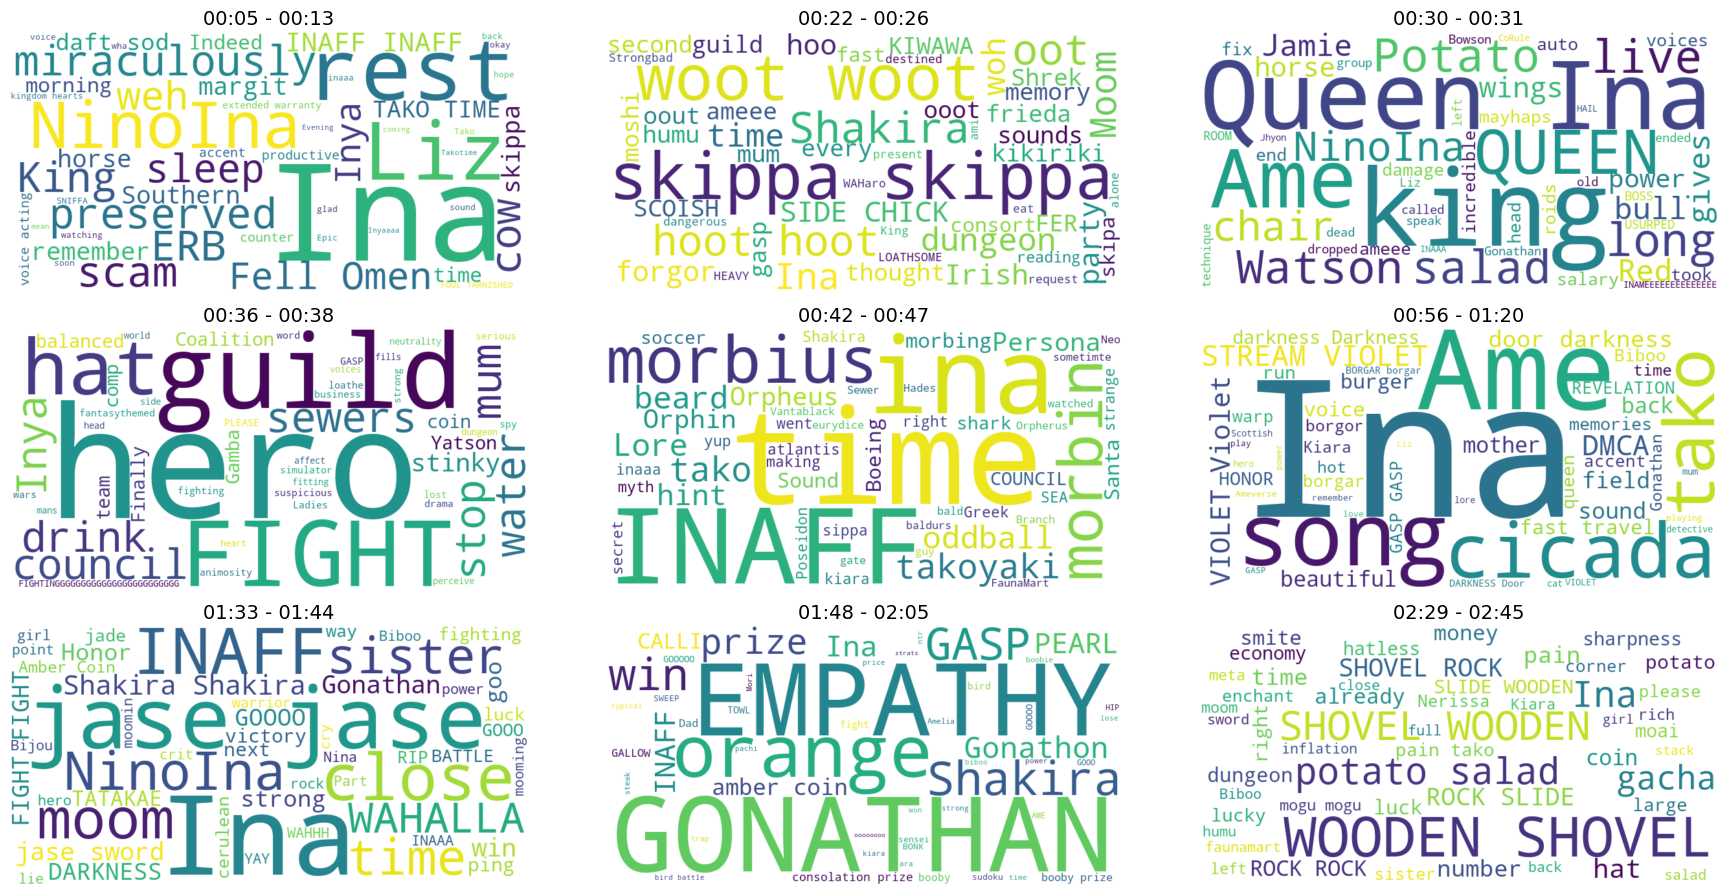

In [103]:
num_intervals = len(merged_intervals)
cols = 3
rows = math.ceil(num_intervals / cols)

fig, axes = plt.subplots(rows, cols, figsize=(18, 3 * rows))

if rows == 1:
    axes = [axes]

index = -1
for i, time_range in enumerate(merged_intervals):
    index += 1
    start = time_range[0] * 60
    end = time_range[1] * 60
    
    df_filtered = df_origin[(df_origin['time_in_seconds'] >= start) & (df_origin['time_in_seconds'] <= end)]
    
    text = ' '.join(df_filtered['cleaned_message'])
    if len(text.strip()) == 0:
        index -= 1
        continue
    
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=50, min_word_length=3).generate(text)
    
    ax = axes[index // cols][index % cols] if rows > 1 else axes[index % cols]
    
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis("off")
    
    ax.set_title(f'{minutes_to_hhmm(time_range[0])} - {minutes_to_hhmm(time_range[1])}', fontsize=14)

for j in range(index + 1, rows * cols):
    fig.delaxes(axes[j // cols][j % cols] if rows > 1 else axes[j % cols])

plt.tight_layout()
plt.show()